In [1]:
import numpy as np
import pandas as pd

In [2]:
CURATED_DATA_34_PATH = "data/curated_34.csv"

curated_data_34 = pd.read_csv(CURATED_DATA_34_PATH)

In [3]:
curated_data_34

,valeur_fonciere,longitude,latitude,nombre_pieces_principales,surface_reelle_bati,code_postal,nom_commune,valeur_mc
0,158730.0,4.086656,43.558880,1.0,25.0,34280.0,La Grande-Motte,6349.200000
1,216000.0,4.014809,43.660787,3.0,43.0,34670.0,Baillargues,5023.255814
2,82000.0,3.891022,43.590893,1.0,21.0,34070.0,Montpellier,3904.761905
3,76000.0,3.846555,43.619867,1.0,30.0,34080.0,Montpellier,2533.333333
4,218500.0,3.886218,43.606132,3.0,70.0,34000.0,Montpellier,3121.428571
...,...,...,...,...,...,...,...,...
1173,54150.0,3.213315,43.345102,3.0,30.0,34500.0,Béziers,1805.000000
1174,114000.0,3.215119,43.340108,3.0,91.0,34500.0,Béziers,1252.747253
1175,74000.0,3.216692,43.339397,2.0,50.0,34500.0,Béziers,1480.000000
1176,180500.0,3.521735,43.284802,2.0,45.0,34300.0,Agde,4011.111111


# Relations analysis

/Users/soufiane.khoudmi/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='nombre_pieces_principales', ylabel='valeur_mc'>

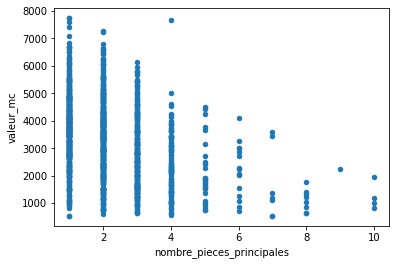

In [4]:
curated_data_34.plot(y="valeur_mc", x="nombre_pieces_principales", kind="scatter")

<Axes: title={'center': 'valeur_mc'}, xlabel='nombre_pieces_principales'>

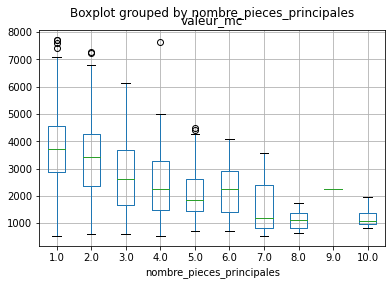

In [5]:
curated_data_34.boxplot("valeur_mc", by="nombre_pieces_principales")

/Users/soufiane.khoudmi/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<Axes: xlabel='surface_reelle_bati', ylabel='valeur_mc'>

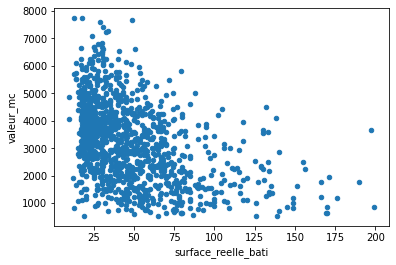

In [6]:
curated_data_34.plot(y="valeur_mc", x="surface_reelle_bati", kind="scatter")

In [7]:
pd.qcut(curated_data_34["surface_reelle_bati"], q=10, labels=list(range(0,10)))

0       2
1       5
2       1
3       3
4       8
       ..
1173    3
1174    9
1175    6
1176    5
1177    8
Name: surface_reelle_bati, Length: 1178, dtype: category
Categories (10, int64): [0 < 1 < 2 < 3 ... 6 < 7 < 8 < 9]

In [8]:
curated_data_34["surface_reelle_bati_qcut"] = pd.qcut(curated_data_34["surface_reelle_bati"], q=10, labels=list(range(0,10)))




<Axes: title={'center': 'valeur_mc'}, xlabel='surface_reelle_bati_qcut'>

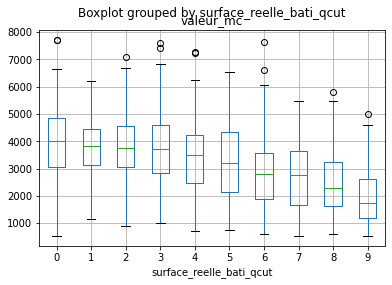

In [9]:
curated_data_34.boxplot("valeur_mc", by="surface_reelle_bati_qcut")

# Test train split

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
target = "valeur_mc"

In [12]:
features = ["surface_reelle_bati", "nombre_pieces_principales", "longitude", "latitude"]

In [13]:
data_train, data_test = train_test_split(
    curated_data_34, test_size=0.33, random_state=42)

In [14]:
data_train.shape

(789, 9)

In [15]:
data_test.shape

(389, 9)

# Average per CP model : the benchmark

In [16]:
mean_per_cp = data_train.groupby('code_postal')['valeur_mc'].mean().to_frame()\
    .rename(columns={'valeur_mc': 'cp_mean_prediction'})

In [17]:
mean_per_cp.head()

,cp_mean_prediction
code_postal,
34000.0,3934.006188
34070.0,2907.202391
34080.0,2250.269619
34090.0,3929.171262
34110.0,2864.413944


## Merge predictions

In [18]:
data_test = data_test.merge(mean_per_cp, on="code_postal")

In [19]:
data_test['mean_per_cp_percent_error'] = np.abs(data_test["cp_mean_prediction"] - data_test["valeur_mc"])/data_test["valeur_mc"]



In [20]:
data_test['mean_per_cp_percent_error'].describe()

count    385.000000
mean       0.326039
std        0.530825
min        0.001122
25%        0.092369
50%        0.216601
75%        0.362957
max        7.317608
Name: mean_per_cp_percent_error, dtype: float64

# Full random forest model

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [22]:
model = GridSearchCV(estimator=RandomForestRegressor(n_estimators=1000, random_state=42),
                     scoring='neg_root_mean_squared_error',
                     param_grid={'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [23]:
model.fit(data_train[features], 
          data_train[target])

GridSearchCV(estimator=RandomForestRegressor(n_estimators=1000,
                                             random_state=42),
             param_grid={'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='neg_root_mean_squared_error')

In [24]:
model.cv_results_

{'mean_fit_time': array([1.63726916, 1.35849271, 1.28344474, 1.258881  , 1.31362734,
        1.2375886 , 1.20344601, 1.17508059, 1.1571383 , 1.1619472 ]),
 'std_fit_time': array([0.09041655, 0.01782499, 0.02215933, 0.0483709 , 0.05934826,
        0.02333243, 0.03856823, 0.02705797, 0.02006785, 0.02649808]),
 'mean_score_time': array([0.07685943, 0.06364164, 0.06798291, 0.06248784, 0.07174621,
        0.06391745, 0.06257572, 0.05998936, 0.06027861, 0.06134458]),
 'std_score_time': array([0.01156077, 0.00152231, 0.00951384, 0.00203532, 0.01915405,
        0.00488911, 0.00539074, 0.00231231, 0.00229039, 0.0037822 ]),
 'param_min_samples_leaf': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'min_samples_leaf': 1},
  {'min_samples_leaf': 2},
  {'min_samples_leaf': 3},
  {'min_samples_leaf': 4},
  {'min_samples_lea

In [25]:
model.best_estimator_

RandomForestRegressor(min_samples_leaf=2, n_estimators=1000, random_state=42)

In [26]:
model.predict(data_test[features])[:10]

array([3661.23719969, 3631.52185918, 3631.52185918, 3207.39691679,
       3318.77976077, 3820.5953271 , 4108.73807505, 3038.00233859,
       3641.66548791, 2876.58445444])

In [27]:
data_test["rf_prediction"] = model.predict(data_test[features])

In [28]:
data_test["rf_precent_error"] =  np.abs(data_test["rf_prediction"] - data_test["valeur_mc"])/data_test["valeur_mc"]



In [29]:
data_test["rf_precent_error"].describe()

count    385.000000
mean       0.290847
std        0.461329
min        0.002022
25%        0.079261
50%        0.176228
75%        0.339197
max        5.725239
Name: rf_precent_error, dtype: float64

In [30]:
data_test[data_test["rf_precent_error"] > 1]

,valeur_fonciere,longitude,latitude,nombre_pieces_principales,surface_reelle_bati,code_postal,nom_commune,valeur_mc,surface_reelle_bati_qcut,cp_mean_prediction,mean_per_cp_percent_error,rf_prediction,rf_precent_error
3,25000.0,3.860533,43.605103,1.0,27.0,34070.0,Montpellier,925.925926,2,2907.202391,2.139779,3207.396917,2.463989
5,30000.0,3.892202,43.592591,1.0,20.0,34070.0,Montpellier,1500.000000,1,2907.202391,0.938135,3820.595327,1.547064
53,70000.0,3.873238,43.609920,2.0,46.0,34000.0,Montpellier,1521.739130,6,3934.006188,1.585204,3730.917694,1.451746
117,97000.0,3.877658,43.614968,2.0,56.0,34000.0,Montpellier,1732.142857,7,3934.006188,1.271179,4106.168444,1.370571
128,145000.0,3.873948,43.621084,6.0,170.0,34090.0,Montpellier,852.941176,9,3929.171262,3.606615,2874.010072,2.369529
144,35000.0,4.084553,43.559678,1.0,65.0,34280.0,La Grande-Motte,538.461538,7,4478.711883,7.317608,3621.282502,5.725239
235,72000.0,3.694396,43.400552,3.0,61.0,34200.0,Sète,1180.327869,7,3042.888417,1.578003,2770.850062,1.347526
259,110000.0,3.224235,43.337360,8.0,169.0,34500.0,Béziers,650.887574,9,1552.036805,1.384493,1443.635368,1.217949
267,40000.0,3.220226,43.341772,3.0,60.0,34500.0,Béziers,666.666667,7,1552.036805,1.328055,1466.073891,1.199111
276,35822.0,3.826908,43.615558,2.0,45.0,34080.0,Montpellier,796.044444,5,2250.269619,1.826814,2422.508036,2.043182


# GPS (Latitude longitude) RF only

In [31]:
model_gps = GridSearchCV(estimator=RandomForestRegressor(n_estimators=1000, random_state=42),
                     scoring='neg_root_mean_squared_error',
                     param_grid={'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [32]:
model_gps.fit(data_train[["longitude", "latitude"]], 
              data_train[target])

GridSearchCV(estimator=RandomForestRegressor(n_estimators=1000,
                                             random_state=42),
             param_grid={'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='neg_root_mean_squared_error')

In [33]:
model_gps.best_estimator_

RandomForestRegressor(min_samples_leaf=4, n_estimators=1000, random_state=42)

In [34]:
model_gps.cv_results_

{'mean_fit_time': array([1.34581327, 1.21873245, 1.15108242, 1.14297142, 1.09943347,
        1.08034019, 1.04755859, 1.03484426, 1.02648473, 0.99847765]),
 'std_fit_time': array([0.01951531, 0.01663787, 0.0165898 , 0.06291324, 0.01088902,
        0.01969119, 0.01429308, 0.01008336, 0.02463799, 0.0062    ]),
 'mean_score_time': array([0.07742872, 0.06819496, 0.06690888, 0.07221122, 0.06187277,
        0.06409559, 0.06123862, 0.06043177, 0.06192918, 0.0590723 ]),
 'std_score_time': array([0.00675402, 0.00204978, 0.00342531, 0.01964372, 0.00187617,
        0.00509725, 0.00206338, 0.00072561, 0.00456163, 0.00178684]),
 'param_min_samples_leaf': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'min_samples_leaf': 1},
  {'min_samples_leaf': 2},
  {'min_samples_leaf': 3},
  {'min_samples_leaf': 4},
  {'min_samples_lea

In [35]:
model_gps.predict(data_test[["longitude", "latitude"]])[:10]

array([3172.38346839, 3172.38346839, 3172.38346839, 2766.53444725,
       3605.68124668, 2769.36606135, 3103.96430443, 3409.0431841 ,
       2698.16729443, 2782.35641623])

In [36]:
data_test['rf_gps_predictions'] = model_gps.predict(data_test[["longitude", "latitude"]])

In [37]:
data_test["rf_gps_precent_error"] =  np.abs(data_test["rf_gps_predictions"] - data_test["valeur_mc"])/data_test["valeur_mc"]


In [38]:
data_test['rf_gps_precent_error'].describe()

count    385.000000
mean       0.308263
std        0.531250
min        0.001019
25%        0.093232
50%        0.187553
75%        0.333684
max        7.316733
Name: rf_gps_precent_error, dtype: float64

# Business simulation 

## Assumptions

In [39]:
user_predictions_per_month = 1000

In [40]:
accuracy_thereshold = 0.05 #  an accurate prediction is 5%

In [41]:
accurate_prediction_conversion_rate = 0.01  # 1% conversion rate for accurate predictions

In [42]:
client_fees_on_value = 0.03

In [43]:
average_house_price = 150000 # Could be different for each since model

## Computations

In [44]:
average_cp_accuracy = (data_test["mean_per_cp_percent_error"] < accuracy_thereshold).mean()


In [45]:
average_cp_accuracy

0.12207792207792208

In [46]:
average_rf_accuracy = (data_test["rf_precent_error"] < accuracy_thereshold).mean()


In [47]:
average_rf_accuracy

0.15064935064935064

In [48]:
average_gps_rf_accuracy = (data_test["rf_gps_precent_error"] < accuracy_thereshold).mean()


In [49]:
average_gps_rf_accuracy

0.14545454545454545

# Results

In [50]:
user_predictions_per_month*average_cp_accuracy*accurate_prediction_conversion_rate*average_house_price*client_fees_on_value



5493.506493506493

In [51]:
user_predictions_per_month*average_rf_accuracy*accurate_prediction_conversion_rate*average_house_price*client_fees_on_value


6779.220779220779

In [52]:
user_predictions_per_month*average_gps_rf_accuracy*accurate_prediction_conversion_rate*average_house_price*client_fees_on_value


6545.454545454544